In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 10 March 2024
# Description:
#     this script get the variables along/across 1500m to calculate the vert-integ heat transport:


In [2]:

import xarray as xr
import pandas as p
import numpy as  np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34037,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33773,Total threads: 4
Dashboard: /proxy/35851/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:39615,


In [4]:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

In [5]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC


### load variables (vol&heat transp, T,S, z, distance, lat/lon) along/across the contour:

#### 1500m isobath

In [6]:
# load ice draft to create masks
expt = 'WAOM10'

ds = xr.open_dataset(tmp_files_dir + expt + '-T0_vol_trans_1500m_daily_v3')
vol_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '-T0_heat_trans_1500m_daily_v3')
heat_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '-T0_temp_1500m_daily_v3')
temp_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '-T0_salt_1500m_daily_v3')
salt_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '-T0_z_rho_1500m_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_10km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_10km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

In [7]:
# obtain area and distances:
# define along_contour axis with same length for both resolutions:
[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))


In [8]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'


In [9]:
# rho grid for binning:
rho_grid2=np.arange(36.2,37.4,0.025) # for sigma-2
len_rho_grid2=len(rho_grid2)

# use salt and temp along the contour to calculate sigma:
sigma_2_10km = gsw.rho(salt_10km[:,:],temp_10km[:,:],2000) - 1000


In [10]:
Tf =  -3.534879684448242 # coldest temp along 1500m among all three WAOM expts (10km, 4km, 4km-notide)

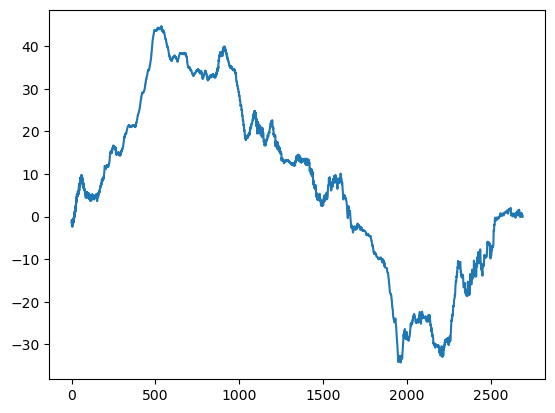

In [11]:
Vol_transp=np.cumsum(np.nanmean(np.sum(vol_transport_10km, axis=1), axis=0), axis=-1)*1e-6

plt.plot(Vol_transp) # convert to Sv

Here is the annual averaged, vertically-integrated, cummulative sum (along contour) volume transport across 1500m isobath.
Integrated Circumpolarly, as expected, there is ~zero volume transport. Sanity check on the SSH averaged over the continental shelf show max variation around ~10cm within a year

PS: are these too high? Like ~40 Sv going south/north just in the Ross or in the West Antarctica sectors? 

### Attempt to calculate mean and eddy heat transport:

To clarify, "heat_transport_10km" is from the model online diagnostic (Huon_Temp, Hvom_temp), which are the triproduct \<dz V T\>. However, T currently is expected to be referenced to -0.28degC (T0 in roms.in), which will have wrong sign when the temperature is negative (mostly everywhere in Antarctic, but NOT ALWAYS).

In [13]:
%time
# WAOM10

# calculate total (<VT>), mean (<V><T>) and eddy (<V'T'>) heat transport components:

# rho0*Cp is only added in the final moment before plotting
# Tf transport is also only subtracted when doing the cumsum.

# Total HT (online diag) annual-avg:
annual_transp_10km = heat_transport_10km.mean('ocean_time') # annual vT x Cp x Rho0

# calculate Mean as v_bar*T_bar, vert-integ or vert-discretised versions:
Vmean = vol_transport_10km.mean('ocean_time')
Tmean = temp_10km.mean('ocean_time')
Mean_transp_vint_10km = Vmean.sum('s_rho')*Tmean.sum('s_rho')
Mean_transp_10km = vol_transport_10km.mean('ocean_time')*(temp_10km.mean('ocean_time')) 

# Eddy heat transport: total - Mean
months=np.arange(0,365)*(1/30.41667)
months_flr = np.floor(months[:])
Eddy_transp_10km = np.empty((365,31,2690)) 
Eddy_transp_vint_10km = np.empty((365,2690)) 

Eddy_vol_transp_10km = np.empty((365,31,2690))
Eddy_temp_10km = np.empty((365,31,2690))
for mm in np.arange(0,365):
    Eddy_transp_10km[mm,:,:] = (heat_transport_10km[mm,:,:]) - Mean_transp_10km
    Eddy_vol_transp_10km[mm,:,:] = vol_transport_10km[mm,:,:] - vol_transport_10km.mean('ocean_time')
    Eddy_temp_10km[mm,:,:] = (temp_10km[mm,:,:]-Tf) - (temp_10km.mean('ocean_time')-Tf)

    # VT = ([mm,:,:])
    Eddy_transp_vint_10km[mm,:] = np.sum(heat_transport_10km[mm,:,:],axis=0) - Mean_transp_vint_10km



CPU times: user 3 µs, sys: 7 µs, total: 10 µs
Wall time: 19.1 µs


In [14]:
# Tf=-0.278 # T0 = Background potential temperature (C) constant for waom10extend_shflim_S_0.25Q simulation;
# currently running a test with T0=-3.6degC to see if the online heat transport diagnostic changes.

Tf=-3.6

# 1) Mean heat transport: average(vol_transp*T)
Tf_heat_transport_10km = Tf*vol_transport_10km.mean('ocean_time')


Text(0.5, 1.0, 'Cross-1500m heat transport minus \n Tf (-3.6degC) heat transport')

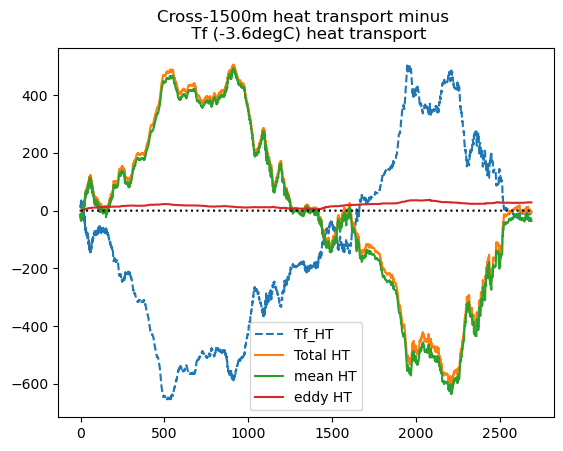

In [15]:
Tf_HT=np.cumsum(np.sum(Tf_heat_transport_10km, axis=0), axis=-1)*rho0*Cp

HT=np.cumsum(np.sum(heat_transport_10km.mean('ocean_time')-Tf_heat_transport_10km, axis=0), axis=-1)*rho0*Cp

meanHT=np.cumsum(np.sum((Mean_transp_10km-Tf_heat_transport_10km), axis=0), axis=-1)*rho0*Cp

eddyHT=np.cumsum(np.nanmean(np.sum(Eddy_transp_10km, axis=1), axis=0), axis=-1)*rho0*Cp


plt.plot(Tf_HT*1e-12,'--', label='Tf_HT') # convert to TW
plt.plot((HT)*1e-12, label='Total HT') 
plt.plot((meanHT)*1e-12, label='mean HT') 
plt.plot((eddyHT)*1e-12, label='eddy HT') 

plt.plot(HT*0,':k')
plt.legend()
plt.title('Cross-1500m heat transport minus \n Tf (-3.6degC) heat transport')

If I use Tf with a very negative value (-3.6degC is the min temp along 1500m in all WAOM10/4/4-notide expts) and then subtract it from the mean transport (Tf x \<vol_transp\>), the latter is so much dominant over the heat transport diagnosed by the model (total, mean, eddy, all based on VT where T should mostly be smaller than abs(-3.6)) that it dominates the spatial variability. The net integrated cross-1500m heat transport around Antarctica is around zero too; just like the volumet transport. Mean advection of heat slightly contributes to Sward heat transport and eddies to Nward HT when integrated around Antarctica, but both spatial variability look the same.



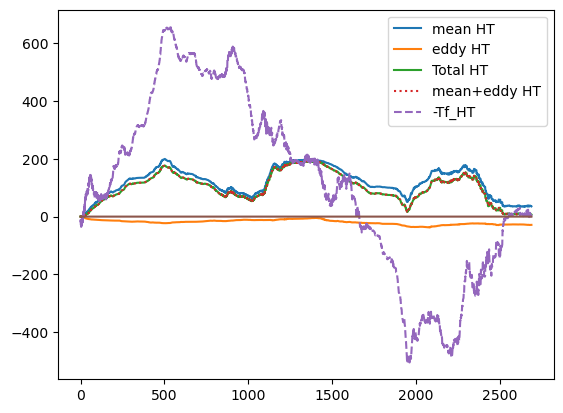

In [16]:
# Testing without subtract Tf x vol_transport:

Tf_HT=np.cumsum(np.sum(Tf_heat_transport_10km, axis=0), axis=-1)*rho0*Cp

HT=np.cumsum(np.sum(heat_transport_10km.mean('ocean_time'), axis=0), axis=-1)*rho0*Cp

meanHT=np.cumsum(np.sum((Mean_transp_10km), axis=0), axis=-1)*rho0*Cp

eddyHT=np.cumsum(np.sum(np.nanmean(Eddy_transp_10km, axis=0), axis=0), axis=-1)*rho0*Cp


plt.plot(-(meanHT)*1e-12, label='mean HT') # convert to TW
plt.plot(-eddyHT*1e-12, label='eddy HT') # convert to TW
plt.plot(-(HT)*1e-12, label='Total HT') # convert to TW
plt.plot(-(meanHT+eddyHT)*1e-12,':', label='mean+eddy HT') # convert to TW

plt.plot(-Tf_HT*1e-12,'--', label='-Tf_HT') # convert to TW
plt.plot(HT*0)
plt.legend()

The total/mean/eddy plot above is not considering Tf (expected to be referenced to -0.278degC), but given the direction of the vert-integ. volume transport (i.e., opposite of Tf_HT, plotted in dashed purple line here), they were multiplied by -1 to agree in direction.

If the direction could just be adjusted like this, the diagnosed heat transport wouldn't lose as much spatial information. I feel like applying Tf HT makes it just look like the volume transport (v-int). For some reason, the online diagnostics are much smoother, but retain the same direction (i.e., north/southward)

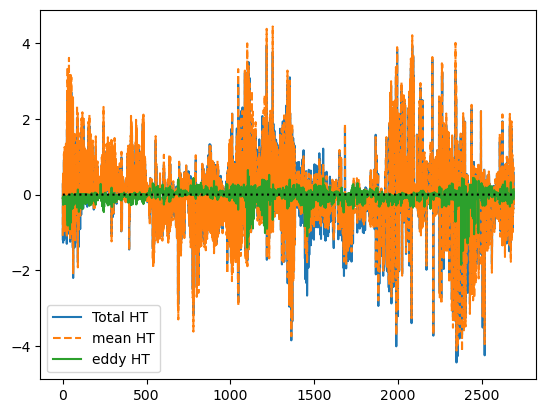

In [16]:
# now trying to plot the same as above (without subtracting Tf heat transport) but without cumsum:

Tf_HT=np.sum(Tf_heat_transport_10km, axis=0)*rho0*Cp

HT=np.sum(heat_transport_10km.mean('ocean_time'), axis=0)*rho0*Cp

meanHT=np.sum((Mean_transp_10km), axis=0)*rho0*Cp

eddyHT=np.sum(np.nanmean(Eddy_transp_10km, axis=0), axis=0)*rho0*Cp


plt.plot(-(HT)*1e-12,'-', label='Total HT') # convert to TW
plt.plot(-(meanHT)*1e-12,'--', label='mean HT') # convert to TW
plt.plot(-(eddyHT)*1e-12, label='eddy HT') # convert to TW
plt.plot(HT*0,':k')
plt.legend()
# plt.xlim(0,20)

Text(0.5, 1.0, 'Advective cross-1500m volume transport')

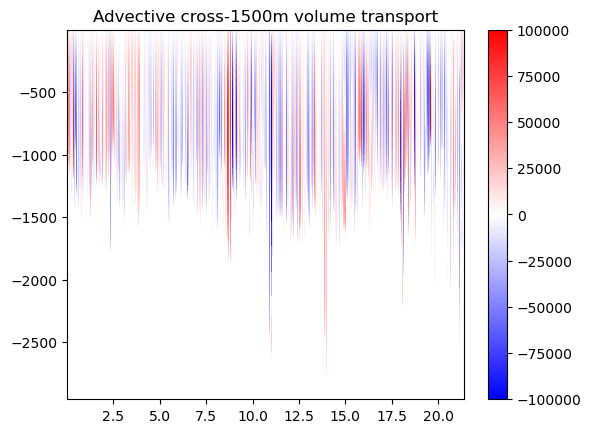

In [17]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),vol_transport_10km.mean('ocean_time'), vmin=-.1e6, vmax=.1e6, cmap='bwr') # convert to Sv
plt.colorbar()
plt.title('Advective cross-1500m volume transport')# (Sv)')

Text(0.5, 1.0, 'Tf heat transport')

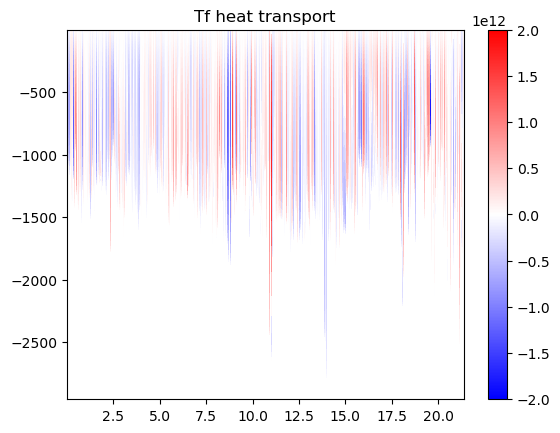

In [18]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),Tf_heat_transport_10km*rho0*Cp, vmin=-2e12, vmax=2e12, cmap='bwr')
plt.colorbar()
plt.title('Tf heat transport')

Text(0.5, 1.0, 'Mean advective cross-1500m heat transport (W)')

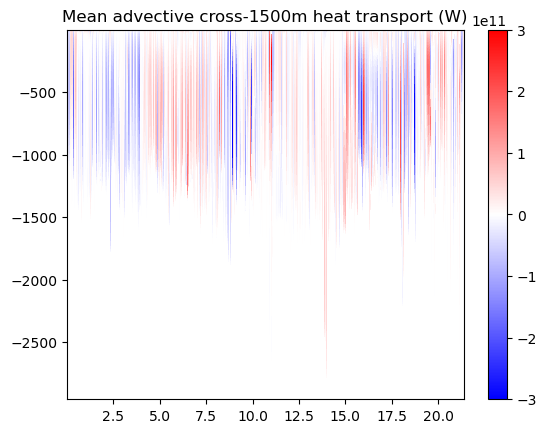

In [19]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),(Mean_transp_10km)*rho0*Cp, vmin=-3e11, vmax=3e11, cmap='bwr')
plt.colorbar()
plt.title('Mean advective cross-1500m heat transport (W)')

Text(0.5, 1.0, 'Annual advective cross-1500m heat transport (W)')

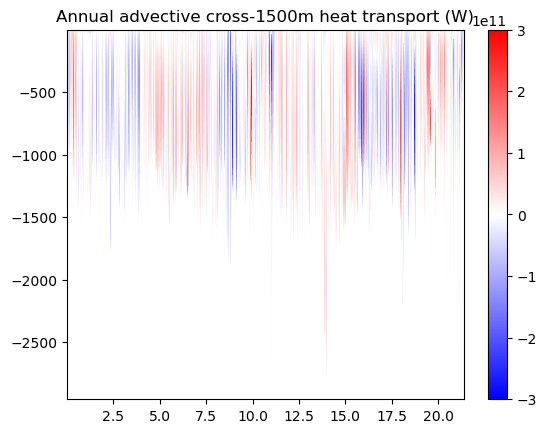

In [20]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),(annual_transp_10km)*rho0*Cp, vmin=-3e11, vmax=3e11, cmap='bwr')
plt.colorbar()
plt.title('Annual advective cross-1500m heat transport (W)')

Text(0.5, 1.0, 'Total - mean advective cross-1500m heat transport (W)')

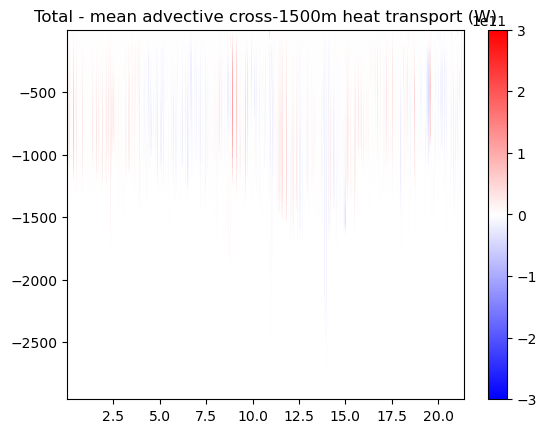

In [21]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),(annual_transp_10km-Mean_transp_10km)*rho0*Cp, vmin=-3e11, vmax=3e11, cmap='bwr')
plt.colorbar()
plt.title('Total - mean advective cross-1500m heat transport (W)')

Text(0.5, 1.0, 'Eddy advective cross-1500m heat transport (W)')

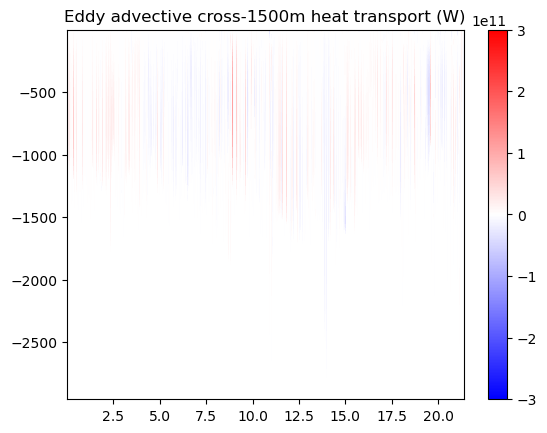

In [22]:
plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),np.nanmean(Eddy_transp_10km, axis=0)*rho0*Cp, vmin=-3e11, vmax=3e11, cmap='bwr')
plt.colorbar()
plt.title('Eddy advective cross-1500m heat transport (W)')

(31, 2690)


Text(0.5, 1.0, 'Eddy cross-1500m volume transport (W)')

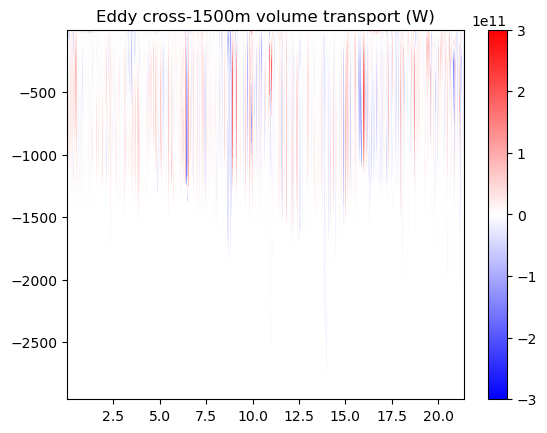

In [23]:
# testing plotting eddy component not annually-averaged (i.e. daily average)
mm=250
Eddy_transp_10km_tst = heat_transport_10km[mm,:,:] - (Mean_transp_10km)#-Tf_heat_transport_10km)
print(Eddy_transp_10km_tst.shape)


plt.pcolormesh(dist_along_axis_10km,z_rho_10km.mean('ocean_time'),Eddy_transp_10km_tst*rho0*Cp ,vmin=-3e11, vmax=3e11, cmap='bwr')
plt.colorbar()
plt.title('Eddy cross-1500m volume transport (W)')

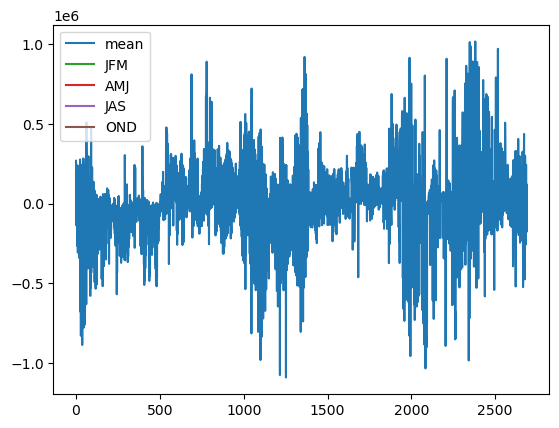

In [24]:
plt.plot(Mean_transp_10km.sum('s_rho'),label='mean')

# plt.plot(np.nansum(Eddy_transp_10km_tst[270,:], axis=0))
# plt.plot(np.nansum(Eddy_transp_10km_tst[90,:], axis=0))
plt.plot(np.mean(np.sum(Eddy_transp_10km_tst, axis=1), axis=0))
plt.plot(np.nanmean(np.nansum(Eddy_transp_10km_tst[0:90,:], axis=1), axis=0),label='JFM')
plt.plot(np.nanmean(np.nansum(Eddy_transp_10km_tst[91:180,:], axis=1), axis=0),label='AMJ')
plt.plot(np.nanmean(np.nansum(Eddy_transp_10km_tst[181:270,:], axis=1), axis=0),label='JAS')
plt.plot(np.nanmean(np.nansum(Eddy_transp_10km_tst[271:365,:], axis=1), axis=0),label='OND')
# plt.ylim(-3e13,3e13)
# plt.xlim(1000,2500)
plt.legend()